# Projet Simulation Numérique ENSEEIHT 2021-2022
### Groupe: B2
### Nom: Huc-Lhuillery
### Prénom: Alexia

# Informations pratiques

**Modalités pédagogiques** 

Le projet Simulation Numérique vise à vous faire découvrir un algorithme particulier en lien avec d'autres modules d'enseignement de cette année et d'illustrer certaines notions et propriétés à partir de programmes simples que vous devez écrire ou bien compléter. Le langage de programmation proposé est Python. Une connaissance basique de Python et de Numpy est suffisante. 

Cette année, il vous est demandé en premier lieu un travail de compréhension des algorithmes principaux sur la base du C/TD du 11/3/22 et des liens en fin de Notebook. Ensuite est demandé un travail d'implantation informatique simple (partie A) et quelques applications sur des images vous sont proposées (partie B). Ce travail est notamment guidé, des questions de compréhension sur les algorithmes sont posées en Partie C. La partie D vous permet d'implanter un algorithme populaire à titre de comparaison. Le volume de travail demandé est raisonnable.

**Enseignement à distance**

Voici les informations concernant les séances (date, heure):

11/3/22 14.00-16.00 C/TD Groupes B1 et B2 (B306)

15/3/22 14.00-18.00 TP Groupe B1 (C306-C204)

18/3/22 08.00-12.00 TP Groupe B2 (C203)

25/3/22 14.00-16.00 TD Séance de réponse à vos questions éventuelles (B306)

**Evaluation**

L'évaluation se basera uniquement sur le Notebook que vous devrez rendre. 

**Date limite de rendu**:  20 avril 2022

**Contact**: xavier.vasseur@isae-supaero.fr

Merci d'indiquer [N7-PSN] en sujet de votre email pour m'aider à identifier vos requêtes.

**Préambule** L'objectif de ce projet est d'analyser quelques algorithmes de factorisation structurée (déterministe ou aléatoire) de matrices de grande taille. Nous nous intéressons à des algorithmes de factorisation dits "Interpolative Decomposition (ID)" ou "CUR-ID", où l'on cherche à approcher au mieux une matrice en un produit de matrices de rang faible. Les algorithmes seront comparés si possible sous différents angles: temps de calcul, complexité opératoire, précision numérique notamment. Nous envisagerons également l'utilisation d'algorithme dit de factorisation non-négative en fin de projet.

**NB:** Il vous est demandé d'insérer vos commentaires et codes **uniquement** dans ce fichier Notebook. Vous avez toute liberté pour créer des cellules soit de texte soit de code. Vous devez disposer comme données de ce fichier et de quelques images au format .jpg. Le rendu sera uniquement ce fichier Notebook dans lequel vous devez insérer l'ensemble de vos résultats. 

Ce projet est en lien notamment avec les cours suivants:

   * Calcul scientifique
   * Algèbre linéaire pour le data mining
   * Optimisation II

In [1]:
#
# Chargement des bibliotheques pour la visualisation, l'algebre lineaire et l'analyse du temps de calcul 
#
import matplotlib.pyplot as plt
import numpy as np
from   scipy import fftpack
from   scipy.linalg import qr, norm, solve_triangular, svd
from   PIL import Image
import time

### Introduction.

L'approximation de rang faible que nous utiliserons dans ce projet se base sur une connaissance du rang exact ou du rang approché de la matrice étudiée. A titre informatif, la méthode suivante vous permet d'obtenir une majoration du rang d'une matrice rectangulaire $A$ telle que $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$, $\epsilon$ désignant une tolérance choisie par l'utilisateur. Cette méthode sera donc utile par la suite dans vos expérimentations numériques, aucune modification n'est a priori requise. 


In [2]:
def adaptive_rank_determination(A,epsilon,blocking=16,iteration_max=10):
    """
    Adaptive rank determination based on randomization
    We look for an orthogonal matrix Q such that 
    $\|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    where $\|.\|_F$ denotes the Frobenius norm.
    
    Reference: Adapted from Section 12 of P.G. Martinsson, "Randomized methods for matrix computations", 2019, 
    ArXiv 1607.01649 [https://arxiv.org/pdf/1607.01649.pdfs]. The original algorithm corresponds to 
    Figure 12. 
    
    Input: 
    A:        matrix to be analysed [array type] (of shape (m,n))
    epsilon:  relative threshold related to the accuracy of the projection (in the Frobenius norm) (0<= epsilon <= 1)
    blocking: blocking parameter to be used in the implementation (for efficiency reasons) [int]
    
    Output:
    Q: matrix with orthonormal columns such that $ \|A - Q Q^T A \|_F \le \epsilon \|A \|_F$
    erank: estimated rank (upper bound of epsilon-rank(A)), erank is here a multiple of min(blocking,n). 
    ratio: current ratio of $\|A - Q Q^T A \|_F4$ divided by $\|A \|_F$
    iteration: nombre d'itérations réalisé au sein de l'algorithme
    """ 
    
    m, n          = A.shape[:]
    # The blocking parameter should be less than the number of columns
    b             = min(blocking,n)
    iteration     = 0
    # Update the maximal number of iterations according to b
    iteration_max = max(np.ceil(n/b),iteration_max) 
    norm_A_Fro = norm(A,'fro')
    
    while norm(A,'fro') > epsilon*norm_A_Fro and iteration < iteration_max:
        # Create R the random block based on Gaussian variables
        R      = np.random.randn(n,b)
        # Matrix-matrix product Y = AR 
        Y      = A@R
        # QR decomposition of Y
        QY, RY = qr(Y,mode='economic')
        # Compute the projection 
        BY     = QY.T@A
        # Concatenate the information related to Q and B
        if iteration == 0:
            Q  = QY
            B  = BY
        else:
            Q  = np.concatenate((Q, QY),axis=1)
            B  = np.concatenate((B, BY),axis=0)
        # Update the iteration count
        iteration += 1
        # Update of A
        A = A - QY@BY
        # Upper bound of epsilon-rank
        erank = Q.shape[1]
        
    return Q, Q.shape[1], norm(A,'fro')/norm_A_Fro, iteration

## Partie A.1

Proposer une implantation des différents algorithmes de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie C). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [3]:
def column_ID(A,k):
    """
    Compute a column interpolative decomposition such that 
    A \approx A[:,J] Z
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    J  is the set of column indices [array, any type] (of shape k)
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    Z    = np.zeros(shape=(k,n))

    # A = QR = (Q1 Q2)(R11 R12)
    #                 (0   R22)
    # le produit Q1 R11 correspond aux k premières colonnes de A
    # et on cherche T tel que R11 T = R12
    
    # Perform the economic decomposition of A with column pivoting 
    Q,R,P = qr(A, mode='economic', pivoting=True)
    
    R11, R12 = R[:k,:k], R[:k,k:]
    
    # Deduce the T=R11^{-1}R12 block 
    T = solve_triangular(R11, R12)
    
    # On récupère ensuite les données J et Z telles que :
    # Z = [Ik T](Pc)t
    # J correspond aux k premières colones de P la matrice de permutation 
    # de la décomposition QR de A 
    
    # Deduce J and Z 
    Z[:,P] = np.concatenate((np.identity(k),T),axis=1) 
    J = P[:k]

    return J,Z


def row_ID(A,k):
    """
    Compute a row interpolative decomposition such that 
    A \approx X A[I,:] 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array, any type] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k))
    
    # On fait de même mais en récupérant les informations contenues 
    # dans les k premières lignes de A 
    
    # Perform the economic decomposition of A^T with column pivoting 
    Q,R,P = qr(A.T, mode='economic', pivoting=True)
    R11, R12 = R[:k,:k], R[:k,k:]
        
    # Deduce the corresponding T block 
    T = solve_triangular(R11, R12)
    
    # Deduce I and X 
    X[P,:] = np.concatenate((np.identity(k),T),axis=1).T
    I = P[:k]
    
    return I,X

def double_sided_ID(A,k):
    """
    Compute a double sided interpolative decomposition such that 
    A \approx X A(I,J) Z 
    
    Input: 
    A matrix to be analysed [array type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    
    Output:
    I  is the set of row indices [array] (of shape k)
    J  is the set of column indices [array] (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    Z  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 10.3 and Figure 7 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    # Apply the column ID to A
    J,Z = column_ID(A,k)
    
    # Apply the row ID to A[:,J]
    I,X = row_ID(A[:,J],k)
    
    return I,J,X,Z

def extract_subblock(A,I,J):
    """
    Given a set of row and column indices, extract the submatrix 
    B = A[I,J]
    with I the set of row indices and J the set of column indices.
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    I  is the set of row indices  (of shape k)
    J  is the set of column indices  (of shape k)
    
    Output:
    Matrix A[I,J] [array] (of shape (k,k))
    """
    B = np.zeros(shape=(len(I),len(J)))
    row_index = 0
    
    for i in I:
        col_index = 0
        for j in J:
            B[row_index,col_index] = A[i,j]
            col_index = col_index + 1
            
        row_index = row_index + 1
    
    return B

def cur(A,k):
    """
    Deterministic version of the CUR algorithm based on the 
    double sided ID decomposition. 
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """
    
    # Apply the double sided interpolation algorithm 
    I,J,X,Z = double_sided_ID(A,k)
    
    # Deduce the C and R matrices of the CUR formulation 
    C = A[:,J]
    R = A[I,:]
    
    # Solve U R = Z in a least-squares sense (pseudo inv) 
    U = Z@(np.linalg.pinv(R))
    
    return I,J,C,U,R

## Partie A.2 

Proposer une implantation des différents algorithmes aléatoires de décomposition vus en cours. Pour vous aider, une définition des fonctions et leurs squelettes sont proposés. Vous avez toute liberté pour les modifier. Ces algorithmes seront utilisés dans la partie de validation (Partie B) et applicative du Notebook (Partie D). Vous pourrez vous appuyer sur les <a href="https://arxiv.org/pdf/1607.01649.pdf">chapitres 10 et 11 des notes de cours de P.G. Martinsson</a>:


In [4]:
def randomized_row_ID(A,k,p=10,q=2):
    """
    Randomized version of the row ID to decompose matrix A into
    A \approx X A(I,:) 
    
    Input: 
    A matrix to be analysed [array] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)
    
    Output:
    I  is the set of row indices  (of shape k)
    X  is the corresponding matrix (of shape (m,k))
    
    Reference: Section 10.4 and Figure 8 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    
    """
    m, n = A.shape[:]
    X    = np.zeros(shape=(m,k)) 
    
    # Use the randomized variant to construct Y an approximation of A
    G = np.random.randn(n,k+p)
    Y = A@G
    
    # Approximation sur q itérations
    for j in range(q):
        Yy = A.T@Y
        Y = A@Yy
        
    # Apply the row ID algorithm to Y
    I,X = row_ID(Y,k)
    
    return I,X

   
def randomized_cur(A,k,p=10,q=2):
    """
    Randomized version of the CUR algorithm     
    
    Input: 
    A matrix to be analysed [any type] (of shape (m,n))
    k: estimated rank of matrix A [int]
    p: oversampling parameter (p=10 by default)
    q: number of power iterations (q=2 by default)  
    
    Output:
    C  is the corresponding matrix (of shape (m,k))
    U  is the corresponding matrix (of shape (k,k))
    R  is the corresponding matrix (of shape (k,n))
    
    Reference: Section 11.2 and Figure 10 of Martinsson's tutorial [https://arxiv.org/pdf/1607.01649.pdf].
    """    
    m, n = A.shape[:]
    
    # Randomized version starts here
    # Use the randomized variant to construct Y an approximation of A
    G = np.random.randn(k+p,m)
    Y = G@A
    
    # Approximation sur q itérations
    for j in range(q):
        Z = Y@(A.T)
        Y = Z@A
    
    # Apply the column ID algorithm to Y 
    J,Z = column_ID(Y,k)
    
    # Apply the row ID algorithm to A[:,J]
    I,X = row_ID(A[:,J],k)
    
    # Deduce the CUR matrices (C, R and then U)
    C = A[:,J]
    R = A[I,:]
    U = Z@(np.linalg.pinv(R))

    return I,J,C,U,R

## Partie B

Nous cherchons à mettre en oeuvre les algorithmes précédents sur une application liée à la reconstruction d'images.
La cellule suivante vous montre comment charger une image et en déduire la matrice associée. Appliquer alors les algorithmes de 
factorisation vus en Partie A et visualiser les images obtenues en fonction du rang estimé.  

(1865, 2797)
Viaduc_de_Millau.jpg

Time spent in the determination of the approximated epsilon-rank 1.071155071258545
Estimated upper bound of the epsilon-rank:  432  for relative threshold:  0.05
Frobenius norm ratio:  0.04968001467992513  reached in  27 iterations
Time spent in the CUR algorithm 1.9609780311584473
Time spent in the randomized CUR algorithm 0.9772558212280273
Time spent in the double sided ID algorithm 1.9505031108856201


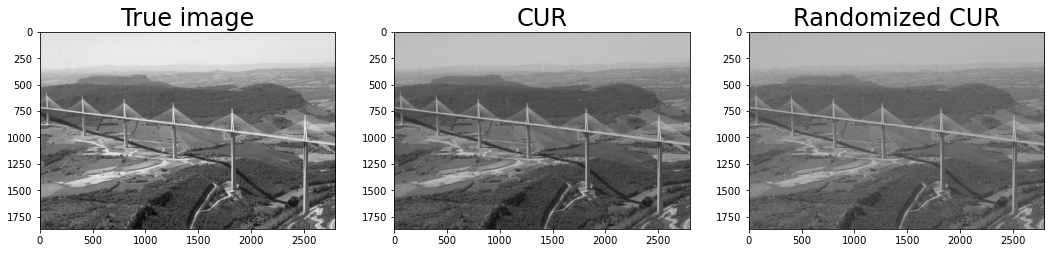

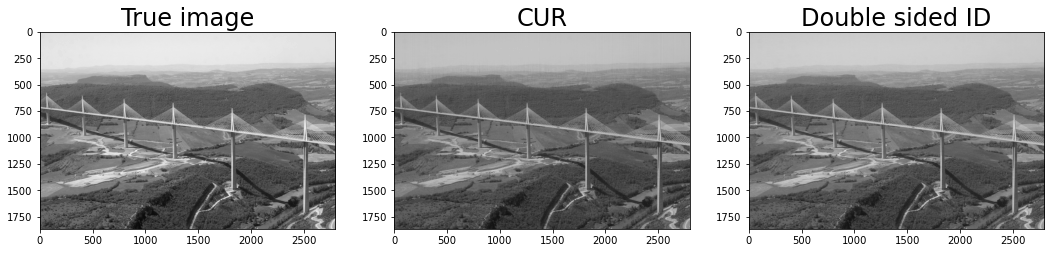

(1266, 2048)
Golden_gate.jpg

Time spent in the determination of the approximated epsilon-rank 0.5160858631134033
Estimated upper bound of the epsilon-rank:  320  for relative threshold:  0.05
Frobenius norm ratio:  0.04878325746700455  reached in  20 iterations
Time spent in the CUR algorithm 0.9325423240661621
Time spent in the randomized CUR algorithm 0.5129537582397461
Time spent in the double sided ID algorithm 0.7533237934112549


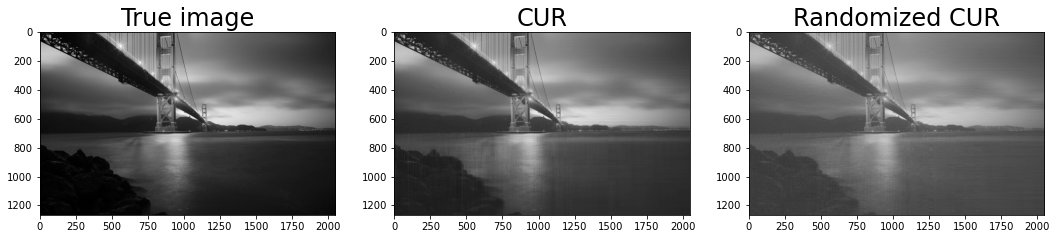

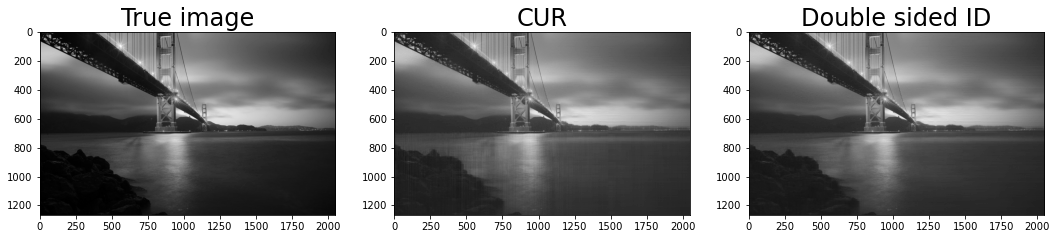

(430, 1024)
Sydney_harbour_bridge_dusk.jpg

Time spent in the determination of the approximated epsilon-rank 0.05993986129760742
Estimated upper bound of the epsilon-rank:  240  for relative threshold:  0.05
Frobenius norm ratio:  0.04403842681800596  reached in  15 iterations
Time spent in the CUR algorithm 0.12674617767333984
Time spent in the randomized CUR algorithm 0.11375904083251953
Time spent in the double sided ID algorithm 0.09685873985290527


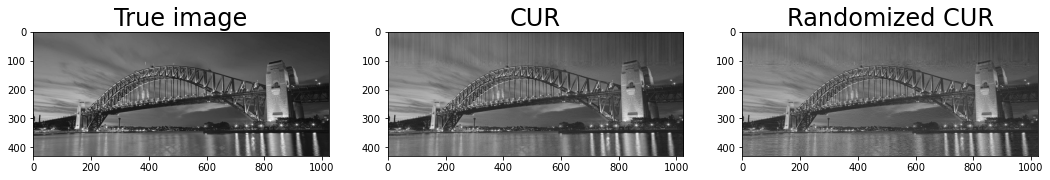

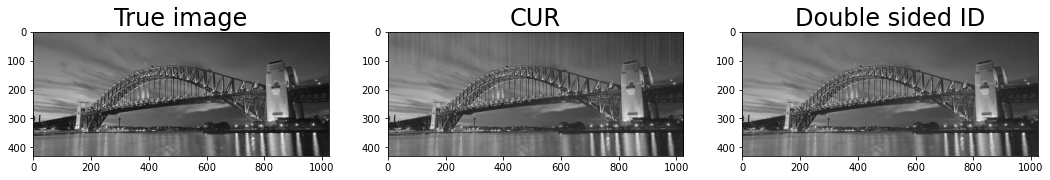

In [5]:
#
# Lecture de l'image parmi Golden_gate.jpg Viaduc_de_Millau.jpg et Sydney_harbour_bridge_dusk.jpg
#
for i in ["Viaduc_de_Millau.jpg", "Golden_gate.jpg", "Sydney_harbour_bridge_dusk.jpg"]:
    imgc = Image.open(i)
    #
    # Conversion de l'image RGB en mode gris et normalisation
    #
    img      = np.array(imgc)
    R        = img[:, :, 0]
    G        = img[:, :, 1]
    B        = img[:, :, 2]
    img_gray = R * 299. / 1000 + G * 587. / 1000 + B * 114. / 1000
    
    M        = (1./255)*np.array(img_gray)
    
    #
    # Affichage de la taille de l'image et de l'image en gris si besoin
    #
    print(np.shape(M))
    print(i)
    print()
    #plt.figure()
    #plt.imshow(M,'gray')
    #
    # Constantes utiles par la suite
    #
    m     = np.shape(M)[0] # nombre de lignes de la matrice M
    n     = np.shape(M)[1] # nombre de colonnes de la matrice M
    
    #
    # Application of the ID/CUR algorithms to M with erank as target rank
    #
    epsilon  = 5.e-2
    blocking = 16
    t_start  = time.time()
    Q, erank, norm_ratio, iteration = adaptive_rank_determination(M,epsilon,blocking)
    print("Time spent in the determination of the approximated epsilon-rank",time.time()-t_start) 
    print("Estimated upper bound of the epsilon-rank: ",erank, " for relative threshold: ",epsilon)
    print("Frobenius norm ratio: ",norm_ratio, " reached in ", iteration, "iterations")
    #
    # CUR algorithm
    #
    t_start        = time.time()
    I,J,C, U, R    = cur(M,erank)
    JCUR_D         = C@U@R
    print("Time spent in the CUR algorithm",time.time()-t_start)
    #
    # Randomized CUR algorithm
    #
    p = 5
    q = 1
    t_start        = time.time()
    I, J, C, U, R  = randomized_cur(M,erank,p,q)
    JCUR_R         = C@U@R
    print("Time spent in the randomized CUR algorithm",time.time()-t_start) 
    #
    # Double sided ID
    #
    t_start        = time.time()
    I,J,X,Z        = double_sided_ID(M,erank)
    JID            = X @ extract_subblock(M,I,J) @ Z
    print("Time spent in the double sided ID algorithm",time.time()-t_start)
    #
    # Plots
    #
    plt.figure(figsize=(18,18))
    plt.subplot(1,3,1)
    plt.imshow(M,'gray')
    plt.title('True image',fontsize=24)
    plt.subplot(1,3,2)
    plt.imshow(JCUR_D,'gray')
    plt.title('CUR',fontsize=24)
    plt.subplot(1,3,3)
    plt.imshow(JCUR_R,'gray')
    plt.title('Randomized CUR',fontsize=24)
    plt.show()

    plt.figure(figsize=(18,18))
    plt.subplot(1,3,1)
    plt.imshow(M,'gray')
    plt.title('True image',fontsize=24)
    plt.subplot(1,3,2)
    plt.imshow(JCUR_D,'gray')
    plt.title('CUR',fontsize=24)
    plt.subplot(1,3,3)
    plt.imshow(JID,'gray')
    plt.title('Double sided ID',fontsize=24)
    plt.show()

**Commentaires:**
Observez-vous des différences de qualité de reconstruction entre les algorithmes pour une précision identique ?

CUR / Randomized CUR : 
Pour une précision identique, l'utilisation de l'algorithme aléatoire CUR renvoie une image avec moins de contraste que l'utilisation de la méthode CUR lorsque la taille de l'image est grande, et renvoie une image très similaire pour une image plus petite. Cependant pour une image de plus en plus grande (exemple du Viaduc de Millau), la méthode aléatoire se révèle de plus rapide que la méthode CUR. Le calcul de la reconstruction est plus long pour une valeur de q plus élevée avec la méthode aléatoire, et l'image perd logiquement en qualité lors de la reconstruction pour un nombre q élevé. 

CUR / Double sided ID : 
La méthode CUR ne permet pas de récupérer entièrement les dégradés de couleur lors de la reconstruction, par rapport à la double décomposition qui renvoie une image presque identique avec seulement des contrastes moins marqués que l'image d'origine. 
De plus, la méthode de double décomposition est légèrement plus rapide que la méthode CUR avec toutes les tailles d'image au départ, et cette différence augmente lorsque la précision augmente (c'est-à-dire quand le epsilon choisi diminue). 

CUR : 
Si l'on augmente la valeur de epsilon, les dégradés de couleurs sur l'image reconstruite par la méthode CUR sont de moins en moins net, des traits plus nombreux et plus gros apparaissent sur l'image. 



## Partie C.

En vous basant notamment sur les notes de cours, les chapitres 10 et 11 de <a href="https://arxiv.org/pdf/1607.01649.pdf">Martinsson (2019)</a>, la section 13 de <a href="https://arxiv.org/pdf/2002.01387.pdf">Martinsson et Tropp (2020)</a>,  répondre aux deux questions suivantes:

* C.1 Donner les avantages et inconvénients éventuels de la décomposition déterministe ID. 

**Réponse**:

La décomposition déterministe ID permet généralement une réduction de la taille des matrices et donc un stockage moins important en mémoire que les méthodes de factorisation QR ou SVD. Cette méthode permet aussi d'analyser les données présentes à l'aide des indices des colonnes ou lignes de couvrement, et de conserver le sens physique des problèmes lorsque l'on applique cette méthode à de la discrétisation d'EDP ou d'équations intégrales. De plus, si A est creuse ou définie positive, la matrice C garde les mêmes propriétés que A. \
Mais cette méthode n'est efficace que si A est réellement de rang k, car sinon la décomposition ID avec le rang k donne une approximation dont l'erreur est plus grande que l'erreur théorique prévue.  

* C.2 Expliquer les raisons qui ont conduit à proposer des variantes aléatoires des algorithmes basés sur la décomposition déterministe ID. 

**Réponse**:

Comme cela peut se voir dans les reconstructions précédentes, pour des données de grande taille les méthodes aléatoires sont plus rapides que les méthodes déterministes car la complexité est plus faible, ce qui est vrai surtout si la précision d'image demandée est peu importante. Pour une méthode aléatoire rapide, la complexité peut désendre jusqu'à $O(mn \log(k))$.

## Partie D.

Appliquer l'algorithme de factorisation non-négative de <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Lee et Cheung</a> (Théoreme 1). Vous pourrez à cet effet utiliser les fonctions multiply et divide de NumPy. 

Time spent in the non-negative matrix factorization (NMF) 15.048367261886597
Norm ratio:  0.06860149044680562  reached in  500 iterations


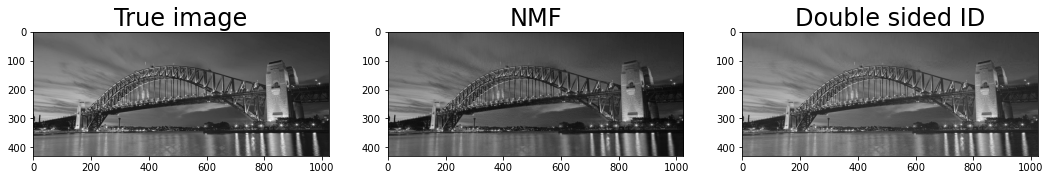

In [6]:
# Non-negative Matrix Factorization 

# On effecture la recherche de M = XY 
# avec X matrice de taille (m,k), Y de taille (k,n), M de taille (m,n)
# qui sont des matrices positives 
X = np.random.rand(m,erank) 
Y = np.random.rand(erank,n)

norm_A_Fro    = norm(M,'fro')
iteration     = 0
iteration_max = 500
t_start       = time.time()

# NMF algorithm: utilisation du théorème 1 
# Minimisation de la distance euclidienne entre M et l'approximation des
# matrices X et Y calculées 
#
# On utilise une convergence similaire à celle des autres algorithmes
# dans la recherche de k : la condition d'arrêt est l'itération maximum est atteinte 
# ou la différence entre la matrice réelle et la matrice reconstruite est supérieure 
# à epsilon multiplié par la norme de Frobenius de la matrice, comme ce qui est 
# utilisé pour les autres algorithmes 

while (iteration < iteration_max and norm(M-(X@Y),'fro') > epsilon*norm_A_Fro):
    iteration += 1;

    # Mise-à-jour de Y
    Y = np.multiply(Y, np.divide(X.T@M, X.T@(X@Y)))

    # Mise-à-jour de X 
    X = np.multiply(X, np.divide(M@(Y.T), X@(Y@(Y.T))))

print("Time spent in the non-negative matrix factorization (NMF)",time.time()-t_start)
print("Norm ratio: ",norm(M-X@Y,'fro')/norm_A_Fro, " reached in ", iteration, "iterations") 

#
# Plots
#
plt.figure(figsize=(18,18))
plt.subplot(1,3,1)
plt.imshow(M,'gray')
plt.title('True image',fontsize=24)
plt.subplot(1,3,2)
plt.imshow(X@Y,'gray')
plt.title('NMF',fontsize=24)
plt.subplot(1,3,3)
plt.imshow(JID,'gray')
plt.title('Double sided ID',fontsize=24)
plt.show()

### Commentaires:

Commenter la vitesse de convergence de la méthode et la qualité de l'image reconstruite. Au final, comparer cette méthode avec les méthodes précédentes vues en Partie B.

**Réponse**:

L'algorithme possède une vitesse de convergence beaucoup plus élevée que l'algorithme de double décomposition ID, mais l'image renvoyée est presque exactement la même que l'image réelle.\
Pour une même précision d'epsilon et une même évaluation de la convergence des algorithmes par comparaison avec la norme de Frobenius de la matrice d'origine, l'algorithme NMF est moins rapide car sa complexité est plus élevée mais la différence avec l'image d'origine est très faible comparée aux autres algorithmes. Les méthodes CUR déterministe et aléatoire donnent une qualité d'image inférieure à celle de la méthode double décomposition, et sa vitesse de convergence étant plus faible que la méthode NMF, la double décomposition donne un résultat plus satisfaisant que les autres méthodes. 

### Références  (articles et exposés)

## Articles

* D. Lee and S. Cheung. <a href="https://proceedings.neurips.cc/paper/2000/file/f9d1152547c0bde01830b7e8bd60024c-Paper.pdf">Algorithms for Non-negative Matrix Factorization </a>. Advances in Neural Information Processing Systems 13 (NIPS 2000). 


* P.-G.  Martinsson.  <a href="https://arxiv.org/pdf/1607.01649.pdf">Randomized  methods  for  matrix  computations</a>.  In  M.W.  Mahoney,  J.C.  Duchi,  and  A.C.  Gilbert, editors, The Mathematics of Data, volume 25, chapter 4, pages 187 – 231. American Mathematical Society, IAS/ParkCity Mathematics Series, 2018.


* P.-G.  Martinsson and J. Tropp.  <a href="https://arxiv.org/pdf/2002.01387.pdf">Randomized Numerical Linear Algebra: Foundations & Algorithms</a>. Acta Numerica, 29, pp 403-572, 2020.


* S. Voronin, P.-G.  Martinsson and  <a href="https://users.oden.utexas.edu/~pgm/Pubs/2017_voronin_CUR.pdf">Efficient Algorithms for CUR and Interpolative Matrix Decompositions</a>. Advances in Computational Mathematics, Volume 43, Issue 3, pp 495–516, 2017.

## Exposés

* P.-G.  Martinsson. <a href="https://simons.berkeley.edu/talks/randomized-algorithms-computing-full-matrix-factorizations">Randomized Algorithms for Computing Full Matrix Factorizations</a>, talk given at  
Randomized Numerical Linear Algebra and Applications, September 2018, Simons Institute, Berkeley, 2018.


* P.-G.  Martinsson. <a href="https://www.youtube.com/watch?v=l262Qij6flM">Randomized algorithms for pivoting and for computing interpolatory and CUR factorizations</a>, talk given at E-Numerical Linear Algebra seminars, March 2021.
